In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing necessary functions and libraries
from datetime import date
import typing as t
import warnings
import os
import pathlib
import random
from functools import partial
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
import tensorflow as tf
import keras

from tensorflow.keras import (
    models,
    layers,
    applications,
    preprocessing,
    optimizers,
    callbacks,
)
from tqdm.auto import tqdm
import albumentations as A

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')


In [ ]:
 # Defining config variables
class CONFIG:
    root_dir_path = pathlib.Path(
        "/content/drive/MyDrive/cnn"
    )
    images_path = pathlib.Path(
        "/content/drive/MyDrive/cnn/images/"
    )
    masks_path = pathlib.Path(
        "/content/drive/MyDrive/cnn/masks/"
    )
    classes = [
    ]
    num_classes = len(classes)
    image_size = 256
    train_test_split = 0.85
    verbose = 1
    batch_size = 8
    autotune = tf.data.AUTOTUNE
    seed = 42

In [ ]:
!pip install opencv-python

In [ ]:
# Defining helper function
def prep_file(path: str, n_channels: int) -> tf.Tensor:
    """
    Prepares file at `path` to get an array form

    Args:
        path (str): file path
        n_channels (int): number of channels in the image

    Returns:
        tf.Tensor: image as an array form

    Raises:
        IOError: If the image or mask file cannot be loaded.
    """
    # Read the images
    file = tf.io.read_file(filename = path)

    # Decode the images
    file = tf.image.decode_jpeg(contents = file, channels = n_channels)

    # Convert the image to a Tensor
    file = tf.image.convert_image_dtype(image = file, dtype = tf.float32)

    # Resize the image to the desired dimensions
    file = tf.image.resize(images = file, size = (CONFIG.image_size, CONFIG.image_size))

    # Normalize the image
    file = tf.clip_by_value(file, clip_value_min = 0.0, clip_value_max = 1.0)

    # Final conversion
    file = tf.cast(file, dtype = tf.float32)

    return file


In [ ]:
# Partial functions to make data prep easy
load_and_prep_image = partial(prep_file, n_channels=3)
load_and_prep_mask = partial(prep_file, n_channels=1)

In [ ]:
image_dataloader = tf.data.Dataset.list_files(str(CONFIG.images_path) + "/*.jpg", shuffle=False)
mask_dataloader = tf.data.Dataset.list_files(str(CONFIG.masks_path) + "/*.jpg", shuffle=False)

image_dataloader = image_dataloader.map(lambda x: load_and_prep_image(x), num_parallel_calls=CONFIG.autotune)
mask_dataloader = mask_dataloader.map(lambda x: load_and_prep_mask(x), num_parallel_calls=CONFIG.autotune)

dataloader = tf.data.Dataset.zip((image_dataloader, mask_dataloader))
num_files = dataloader.cardinality().numpy()

train_size = int(CONFIG.train_test_split * num_files)

train_dataloader = dataloader.take(train_size).repeat(3).shuffle(200, seed=CONFIG.seed, reshuffle_each_iteration=True).batch(CONFIG.batch_size).prefetch(1)
test_dataloader = dataloader.skip(train_size).batch(CONFIG.batch_size).prefetch(1)

train_dataloader, test_dataloader

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>)

In [ ]:
#Creating U-Net

In [ ]:
# Building the convolutional block
def ConvBlock(inputs, filters=64):

    # Taking first input and implementing the conv block
    conv1 = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(inputs)
    batch_norm1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(batch_norm1)

    # Taking first input and implementing the second conv block
    conv2 = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(act1)
    batch_norm2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(batch_norm2)

    return act2

# Building the encoder
def encoder(inputs, filters=64):

    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = ConvBlock(inputs, filters)
    max_pool1 = layers.MaxPool2D(strides=(2, 2))(enc1)
    return enc1, max_pool1

# Building the decoder
def redesigned_skip_pathways(inputs, skip,filters):

    # Upsampling and concatenating the essential features
    upsample = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(inputs)
    connect_skip = layers.Concatenate()([upsample, skip])
    out = ConvBlock(connect_skip, filters)
    return out

# Building the model
def U_Net(image_size):
    inputs = layers.Input(image_size)

    # Constructing the encoder blocks and increasing the filters by a factor of 2
    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)

    # Preparing the next block
    conv_block = ConvBlock(encoder_4, 64*16)

    # Constructing the decoder blocks and decreasing the filters by a factor of 2
    decoder_1 = redesigned_skip_pathways(conv_block, skip4, 64*8)
    decoder_2 = redesigned_skip_pathways(decoder_1, skip3, 64*4)
    decoder_3 = redesigned_skip_pathways(decoder_2, skip2, 64*2)
    decoder_4 = redesigned_skip_pathways(decoder_3, skip1, 64)

    # Output layer
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)
    sgd_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.1, decay=0.001)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Your defined functions for IOU and F1 score
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    iou_score = intersection / (union + 1e-7)
    return iou_score

def f1_score(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 1)), tf.float32))
    fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 0)), tf.float32))
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    return f1

# Assuming you have y_true and y_pred defined somewhere
y_true = np.array([0, 1, 1, 0, 1])
y_pred = np.array([0, 1, 0, 0, 1])

# Calculate F1 score
f1 = f1_score(y_true, y_pred)

print("F1 score:", f1)
print(iou)


F1 score: tf.Tensor(0.79999995, shape=(), dtype=float32)
<function iou at 0x7f68c8ed35b0>


In [ ]:
# Creating an instance of the model
INPUT_SHAPE = (256, 256, 3)
# learning_rate = 0.1
model = U_Net(INPUT_SHAPE)

# # Compiling the model
# model.compile(optimizer=Adam(lr=learning_rate, decay=learning_decay_rate), loss='binary_crossentropy', metrics=['acc', iou, f1_score])

model.compile(optimizer="Adam", loss="binary_crossentropy",metrics=['acc', iou, f1_score])
# # # model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# # Create callbacks
CALLBACKS = [
    callbacks.ModelCheckpoint(monitor="val_loss", verbose=1,filepath="U_Net_Forest_Segmentation.h5", save_best_only=True, save_weights_only=False),
    callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]



In [ ]:
model

In [ ]:
NUM_EPOCHS = 50

history_u_net = model.fit(train_dataloader,
                          epochs=NUM_EPOCHS,
                          validation_data=test_dataloader,
                          callbacks=CALLBACKS)

Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 0.8033 - acc: 0.4296 - iou: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.68245, saving model to U_Net_Forest_Segmentation.h5
3/3 [==============================] - 63s 7s/step - loss: 0.8033 - acc: 0.4296 - iou: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6824 - val_acc: 0.7643 - val_iou: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 0.5919 - acc: 0.6239 - iou: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 2: val_loss did not improve from 0.68245
3/3 [==============================] - 2s 478ms/step - loss: 0.5919 - acc: 0.6239 - iou: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 3.2113 - val_acc: 0.0647 - val_iou: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 0.4245 - acc: 0.7227 - iou: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 3: val_loss did not improve from 0.68245
3/3 [========

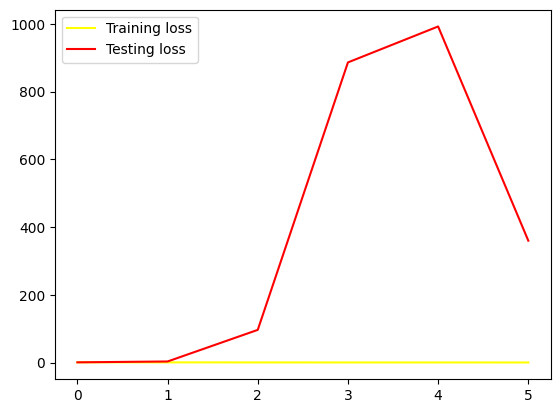

In [ ]:
# Creating an accuracy graph for training and testing data
plt.plot(history_u_net.history['loss'], color='yellow', label='Training loss')
plt.plot(history_u_net.history['val_loss'], color='red', label='Testing loss')
plt.legend()
plt.show()

In [ ]:
# Loading the best weights
model = models.load_model("/content/drive/MyDrive/cnn/U_Net_Forest_Segmentation.h5")

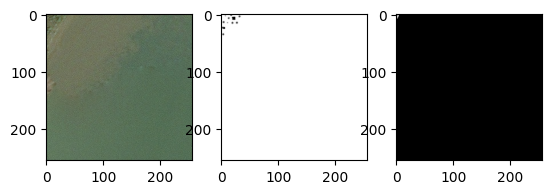

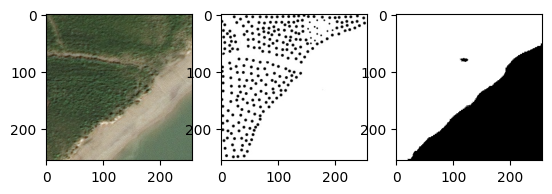

In [ ]:
test_samples = test_dataloader.shuffle(200).take(1)
test_samples_preds = model.predict(test_samples, verbose=0)
test_samples_preds[test_samples_preds >= 0.5] = 1
test_samples_preds[test_samples_preds < 0.5] = 0

for images, masks in test_samples:
    for image, mask, preds in zip(images[:3], masks[:3], test_samples_preds[:2]):
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.imshow(preds, cmap='gray')
        plt.show()
